<a href="https://colab.research.google.com/github/yzR1991/domain_adaptation_notes_experiments/blob/main/Gaussian_Copula_Kendall's_Tau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
import time
import random
import math
import scipy.stats
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
from scipy.integrate import dblquad

In [ ]:
v,e = dblquad(lambda x,y: 2 / (x*y*(x+y-1)**3), 1, np.infty, 1, np.infty)
print(v)

0.2898681325313279


In [ ]:
res = []
for t in np.linspace(0.1,10,num=100,endpoint=True):
    cur, err = dblquad(lambda x,y: (1+t)/(t**2 * x**(1/t) * y**(1/t) * (x+y-1)**(2+1/t)), 1, np.infty, 1, np.infty)
    res.append(cur)

/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)
/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:865: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 


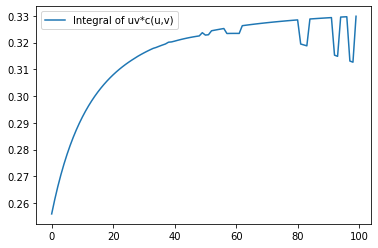

In [ ]:
res = np.array(res)
plt.plot(res,label="Integral of uv*c(u,v)")
plt.legend()
plt.show()

###Test replacement of sign by tanh via Kendall's tau

In [ ]:
size = 10000
a = 10

def KT(x,y):
    x_a, x_b = x[:size//2], x[size//2:]
    y_a, y_b = y[:size//2], y[size//2:]
    res_1 = np.mean(np.sign((x_a - x_b)*(y_a - y_b)))
    res_2 = np.mean(np.tanh(a * (x_a - x_b)*(y_a - y_b)))
    return res_1, res_2

In [ ]:
signs = []
tanhs = []
for t in np.linspace(-1,1,100):
    rv = scipy.stats.multivariate_normal.rvs(cov=[[1,t],[t,1]],size=size)
    aa, bb = KT(rv.T[0],rv.T[1])
    sign, tanh = np.sin(aa*np.pi/2), np.sin(np.pi*bb/2)
    signs.append(sign)
    tanhs.append(tanh)
signs = np.array(signs)
tanhs = np.array(tanhs)

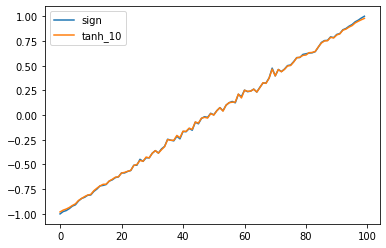

In [ ]:
plt.plot(signs, label="sign")
plt.plot(tanhs, label="tanh_10")
plt.legend()
plt.show()

#Modified Domain Adaptation by Kendall's tau

In [ ]:
class DANN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, drop_rate=0.1):
        super(DANN, self).__init__()
        self.layer1 = nn.Sequential(nn.BatchNorm1d(input_dim), nn.Linear(input_dim, hidden_dim), nn.ReLU())
        self.layer2 = nn.Sequential(nn.BatchNorm1d(hidden_dim), nn.Linear(hidden_dim, hidden_dim // 4), nn.ReLU())
        self.layer3 = nn.Sequential(nn.BatchNorm1d(hidden_dim // 4), nn.Linear(hidden_dim // 4, output_dim))#, nn.ReLU())
        # self.layer4 = nn.Sequential(nn.BatchNorm1d(hidden_dim // 4), nn.Linear(hidden_dim // 4, output_dim))
    
    def forward(self, x, y):
        """
        Extract common features
        Then calculate marginal divergences and the copula distance
        """
        x,y = self.layer1(x), self.layer1(y)
        x,y = self.layer2(x), self.layer2(y)
        # x,y = self.layer3(x), self.layer3(y)
        marginal_div = self.marginal_div(x, y)
        copula_distance = self.copula_distance(x, y)
        x = self.layer3(x)
        # x = nn.functional.softmax(x, dim=1)
        return marginal_div, copula_distance, x

    def gaussian_kernel(self, source, target, kernel_mul=2.0, kernel_num=2, fix_sigma=1.0):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        kernels = sum(kernel_val)
        batch_size = int(source.size()[0])
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size] 
        loss = torch.mean(XX + YY - XY -YX)
        return loss
    
    def predict(self, y):
        y = self.layer1(y)
        y = self.layer2(y)
        y = self.layer3(y)
        # y = self.layer4(y)
        return y

    def marginal_div(self, x, y):
        """
        Calculate the summation of marginal divergences
        For each column vector of 1-dim, change it to a 2-dim matrix first
        Then apply the gaussian kernel function 
        """
        md = 0
        for i in range(x.shape[1]):
            md += self.gaussian_kernel(x[:,i].view(x.shape[0],1), y[:,i].view(y.shape[0],1))
        return md
    
    def Kendall_tau(self, x, y, size):
        x_a, x_b = x[:size], x[size:2*size]
        y_a, y_b = y[:size], y[size:2*size]
        res = torch.tanh(5*(x_a - x_b) * (y_a - y_b))
        return torch.mean(res)

    def copula_distance(self, x, y):
        """
        First we use Kendall's tau to estimate parameters of gaussian copula,
        namely the correlation matrix,
        where torch.sign() is replaced by torch.tanh()
        Then the distance between two copulas is given by
        the Frobenius norm of the differences between correlation matrices
        """
        size = x.shape[0] // 2
        cd = 0
        for i in range(x.shape[1]-1):
            for j in range(i,x.shape[1]):
                # calculate ij-th entries of x,y copulas
                cx_ij = self.Kendall_tau(x[:,i], x[:,j], size)
                cy_ij = self.Kendall_tau(y[:,i], y[:,j], size)
                cd += 2*(cx_ij - cy_ij)**2
        return torch.sqrt(cd)

##FBM experiment

###generating data

In [ ]:
!pip install fbm

In [ ]:
import fbm

In [ ]:
def generate_fBM(n_paths, n_samples, hurst_exponents):
    """
    generate FBM paths
    """
    X = []
    y = []
    for j in range(n_paths):
        hurst = random.choice(hurst_exponents)
        X.append(fbm.FBM(n=n_samples, hurst=hurst, length=1, method='daviesharte').fbm())
        y.append(hurst)
    return np.array(X), np.array(y)

def generate_data(n_paths_train, n_paths_test, n_samples, hurst_exponents):
    """
    generate train and test datasets
    """
    x_train, y_train = generate_fBM(n_paths_train, n_samples, hurst_exponents)
    x_test, y_test = generate_fBM(n_paths_test, n_samples, hurst_exponents)

    y_train = np.expand_dims(y_train, axis=1)
    y_test = np.expand_dims(y_test, axis=1)

    return x_train, y_train, x_test, y_test

In [ ]:
n_paths = 1000
n_samples = 100

hurst_train = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
hurst_test = [0.4,0.5,0.6,0.7]

x_train, y_train = generate_fBM(n_paths=n_paths, n_samples=n_samples, hurst_exponents=hurst_train)
x_test, y_test = generate_fBM(n_paths=n_paths, n_samples=n_samples, hurst_exponents=hurst_test)

/usr/local/lib/python3.7/dist-packages/fbm/fbm.py:172: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  "Combination of increments n and Hurst value H "


In [ ]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

###LET'S GO!

In [ ]:
model = DANN(input_dim = n_samples + 1, hidden_dim = 32, output_dim = 1)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
start = time.time()

n_epoch = 100

endurance = 40

hist = []

train_hist = []

test_hist = []

train_accuracies = []
test_accuracies = []

divergences = []
copula_distances = []

trade_off = 100

count = 0

best_loss = 1e4

for t in range(n_epoch):

    marginal_divergence, copula_distance, y_train_pred = model(x_train, x_test)
    y_test_pred = model.predict(x_test)

    loss_train = loss_fn(y_train_pred, y_train)
    loss_test = loss_fn(y_test_pred, y_test)

    loss = trade_off * loss_train + (marginal_divergence + copula_distance) / trade_off

    # train_index_pred = torch.max(y_train_pred, dim=1)[1].data.numpy()
    # train_acc = sum(train_index_pred == y_train.detach().numpy()) / n_paths

    # test_index_pred = torch.max(y_test_pred, dim=1)[1].data.numpy()
    # test_acc = sum(test_index_pred == y_test.detach().numpy()) / n_paths

    # train_accuracies.append(train_acc.item())
    # test_accuracies.append(test_acc.item())

    if t % 10 == 0 and t !=0:
        # print("Epoch ", t, "Train Acc: ", train_acc, "Test Acc: ", test_acc)
        print("Epoch ", t, "Train MSE: ", loss_train.item(), "Test MSE: ", loss_test.item(), "Marginal Divergence: ", marginal_divergence.item(), "Copula Distance: ", copula_distance.item())
    
    train_hist.append(loss_train.item())
    test_hist.append(loss_test.item())
    hist.append(loss.item())
    divergences.append(marginal_divergence)
    copula_distances.append(copula_distance)

    if loss_train.item() + loss_test.item() < best_loss:
        count = 0
        best_loss = loss_train.item() + loss_test.item()
    else:
        count += 1

    if count >= endurance:
        print('Early stop at {}-th training with best MSE {}'.format(t, best_loss))
        break

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

end = time.time()
print("Model training costs: ", end - start)

Epoch  10 Train MSE:  0.22248388826847076 Test MSE:  0.1983317881822586 Marginal Divergence:  791.42138671875 Copula Distance:  0.7253196239471436
Epoch  20 Train MSE:  0.09493615478277206 Test MSE:  0.042419612407684326 Marginal Divergence:  266.7158508300781 Copula Distance:  10.83121109008789
Epoch  30 Train MSE:  0.0700947493314743 Test MSE:  0.015640858560800552 Marginal Divergence:  83.76901245117188 Copula Distance:  5.608154773712158
Epoch  40 Train MSE:  0.062349747866392136 Test MSE:  0.015771042555570602 Marginal Divergence:  53.33094787597656 Copula Distance:  5.509021282196045
Epoch  50 Train MSE:  0.05966901034116745 Test MSE:  0.013069846667349339 Marginal Divergence:  50.40558624267578 Copula Distance:  5.521759986877441
Epoch  60 Train MSE:  0.05708286166191101 Test MSE:  0.013162954710423946 Marginal Divergence:  56.78923797607422 Copula Distance:  7.7647480964660645
Epoch  70 Train MSE:  0.054904233664274216 Test MSE:  0.012254551984369755 Marginal Divergence:  64.31

In [ ]:
torch.mean(y_train)

tensor(0.4940)

In [ ]:
y_train_pred

In [ ]:
x = model.layer1(x_train)
x = model.layer2(x)
x = model.layer3(x)

In [ ]:
x

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.1133, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0954, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.1200, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0934, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.1299, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0445, 0.0000]],
       grad_fn=<ReluBackward0>)

#Experiment on Synthetic Data

source: (a,b,c), label $\Phi(1-(a+b+c))$.
target: $(\lambda_1*a,b,\lambda_2*e^{-c})$. target hidden label $\Phi(1-(\lambda_1*a+b+\lambda_2*e^{-c}))$.

The distributions are as follow. $a$ normal, $b$ student-t, $c$ gamma, and the copula is Gaussian. So we generate $(z_1,z_2,z_3)$ by a multivariate normal distribution at first, then use it to generate a meta Gaussian distribution.

##Generating synthetic train/test data

In [ ]:
size = 10000
lambda_1 = 1
lambda_2 = 5

In [ ]:
mnormal = scipy.stats.multivariate_normal.rvs(cov=[[1,0.5,0.1],[0.5,1,-0.5],[0.1,-0.5,1]],size=size)

In [ ]:
a = mnormal[:,0]

In [ ]:
student_b = 1.5

b = scipy.stats.norm.cdf(mnormal[:,1])
b = scipy.stats.t.ppf(b, student_b)

In [ ]:
gamma_c = 2

c = scipy.stats.norm.cdf(mnormal[:,2])
c = scipy.stats.gamma.ppf(c, gamma_c)

In [ ]:
#常数取a+b+c的均值

label = scipy.stats.norm.cdf(2 - a - b - c)

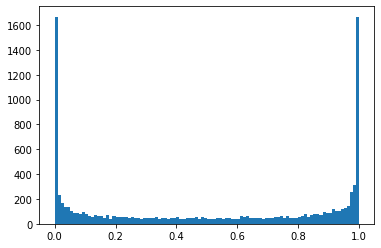

In [ ]:
plt.hist(label, bins=100, range=(0,1))
plt.show()

In [ ]:
x_train = np.array([a,b,c]).T
y_train = label.reshape(-1,1)

In [ ]:
mnormal_test = scipy.stats.multivariate_normal.rvs(cov=[[1,0.5,0.1],[0.5,1,-0.5],[0.1,-0.5,1]],size=size)

In [ ]:
aa = mnormal_test[:,0]*lambda_1

In [ ]:
student_b = 1.5

bb = scipy.stats.norm.cdf(mnormal_test[:,1])
bb = scipy.stats.t.ppf(bb, student_b)

In [ ]:
gamma_c = 2
# upper_bound = 1000

cc = scipy.stats.norm.cdf(mnormal_test[:,2])
cc = scipy.stats.gamma.ppf(cc, gamma_c)
cc = lambda_2 * np.exp(-cc)
# cc[cc > upper_bound] = upper_bound

In [ ]:
label_test = scipy.stats.norm.cdf(2 - aa - bb - cc)

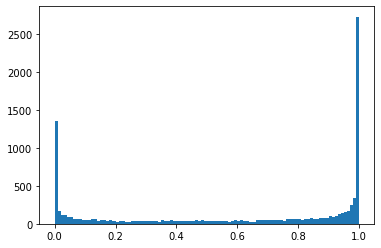

In [ ]:
plt.hist(label_test, bins=100, range=(0,1))
plt.show()

In [ ]:
x_test = np.array([aa,bb,cc]).T

y_test = label_test.reshape(-1,1)

In [ ]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)

x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
torch.mean(y_train).item()

0.5169036388397217

In [ ]:
batch_size = 1000

dataset_train = Data.TensorDataset(x_train, y_train)
dataloader_train = Data.DataLoader(dataset_train, batch_size = batch_size, shuffle = True)

dataset_test = Data.TensorDataset(x_test, y_test)
dataloader_test = Data.DataLoader(dataset_test, batch_size = batch_size, shuffle = True)

In [ ]:
for step, (batch_x, batch_y) in enumerate(dataloader_train):
    print('| Step: ', step, '| batch x: ',
              batch_x.numpy().shape, '| batch y: ', batch_y.numpy().shape)

for step, (batch_x, batch_y) in enumerate(dataloader_test):
    print('| Step: ', step, '| batch x: ',
              batch_x.numpy().shape, '| batch y: ', batch_y.numpy().shape)

| Step:  0 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  1 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  2 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  3 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  4 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  5 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  6 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  7 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  8 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  9 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  0 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  1 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  2 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  3 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  4 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  5 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  6 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  7 | batch x:  (1000, 3) | batch y:  (1000, 1)
| Step:  8

##Test!

--------------------------------------------

In [ ]:
torch.cuda.is_available()

False

In [ ]:
input_dim = 3
hidden_dim = 16
output_dim = 1
num_epochs = 200

In [ ]:
model = DANN(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
hist_train = np.zeros(num_epochs)
hist_test = np.zeros(num_epochs)
mape_train = np.zeros(num_epochs)
mape_test = np.zeros(num_epochs)

t_1 = 10
t_2 = 1
t_3 = 10

best_loss = 1e2
best_train_loss = 1e2
best_test_mape = 1
best_train_mape = 1

endurance = 20
counter = 0

start = time.time()
for t in range(num_epochs):

    train_iter = iter(dataloader_train)
    test_iter = iter(dataloader_test)

    cur_train = 0
    cur_test = 0
    cur_mape_train = np.array([])
    cur_mape_test = np.array([])

    n = size // batch_size
    for i in range(n):
        x_train_iter, y_train_iter = train_iter.next()
        x_test_iter, y_test_iter = test_iter.next()
        # x_train_iter, y_train_iter = x_train_iter.to(DEVICE), y_train_iter.to(DEVICE)
        # x_test_iter, y_test_iter = x_test_iter.to(DEVICE), y_test_iter.to(DEVICE)

        marginal_div, copula_distance, y_train_pred = model(x_train_iter, x_test_iter)

        """
        this part use divergence of total distributions
        """
        # x, y = model.layer1(x_train_iter), model.layer1(x_test_iter)
        # x, y = model.layer2(x), model.layer2(y)
        # x, y = model.layer3(x), model.layer3(y)
        # total_div = model.gaussian_kernel(x,y)
        sqrt = torch.sqrt(loss_fn(y_train_pred, y_train_iter))
        loss = t_1 * sqrt + t_2 * marginal_div + t_3 * copula_distance
        if i - t % 10 == 0:
            print("Epoch ", t, "Batch ", i, "Loss: ", loss.item(), "RMSE: ", sqrt.item(), "Marginal Div: ", marginal_div.item(), "Copula Distance: ", copula_distance.item())
        cur_train += loss_fn(y_train_pred, y_train_iter).item()
        cur_mape_train = np.append(cur_mape_train ,(abs(y_train_pred - y_train_iter) / y_train_iter).detach().numpy())

        optimiser.zero_grad() 
        loss.backward()
        optimiser.step()
    
    """
    Test model performance on target
    Freeze the coefficients at first then free them at last
    """
    test_iter = iter(dataloader_test)
    model.eval()
    for i in range(n):
        x_test_iter, y_test_iter = test_iter.next()
        y_test_pred = model.predict(x_test_iter)
        cur_test += loss_fn(y_test_pred, y_test_iter).item()
        cur_mape_test = np.append(cur_mape_test, (abs(y_test_pred - y_test_iter) / y_test_iter).detach().numpy())
    model.train()
    
    """
    RMSE and median APE of all train and test predictions
    """
    hist_train[t] = np.sqrt(cur_train / n)
    hist_test[t] = np.sqrt(cur_test / n)
    mape_train[t] = np.nanmedian(cur_mape_train)
    mape_test[t] = np.nanmedian(cur_mape_test)

    if t % 10 == 0 and t !=0:
         print("Epoch ", t, "Train MAPE: ", mape_train[t], "Test MAPE: ", mape_test[t])

    """
    Early stop if model performance grows no better on test set for a while
    Record the results when model performs the best
    """
    if hist_test[t] < best_loss:
        counter = 0
        best_loss = hist_test[t]
        best_train_loss = hist_train[t]
        best_train_mape = mape_train[t]
        best_test_mape = mape_test[t]
    else:
        counter += 1
    if counter >= endurance:
        print('Early stop at {}-th training with best test RMSE {}, train RMSE {}'.format(t, best_loss, best_train_loss))
        print("At this time the Train/Test MAPE is: {} , {}".format(best_train_mape, best_test_mape))
        break

end = time.time()
print("Experiment cost {} seconds".format(end - start))

Epoch  0 Batch  0 Loss:  9.857231140136719 RMSE:  0.7300041317939758 Marginal Div:  0.03039591573178768 Copula Distance:  0.25267937779426575
Epoch  1 Batch  1 Loss:  3.9799184799194336 RMSE:  0.3304963707923889 Marginal Div:  0.0053863804787397385 Copula Distance:  0.06695684790611267
Epoch  2 Batch  2 Loss:  3.9324440956115723 RMSE:  0.25334206223487854 Marginal Div:  0.006574932020157576 Copula Distance:  0.13924485445022583
Epoch  3 Batch  3 Loss:  2.9609246253967285 RMSE:  0.22341513633728027 Marginal Div:  0.007060403469949961 Copula Distance:  0.07197128981351852
Epoch  4 Batch  4 Loss:  3.093454599380493 RMSE:  0.2461375743150711 Marginal Div:  0.0024203418288379908 Copula Distance:  0.06296584010124207
Epoch  5 Batch  5 Loss:  3.5043153762817383 RMSE:  0.1804223209619522 Marginal Div:  0.011186404153704643 Copula Distance:  0.1688905656337738
Epoch  6 Batch  6 Loss:  3.674168109893799 RMSE:  0.2316683828830719 Marginal Div:  0.003790650051087141 Copula Distance:  0.13536936044

In [ ]:
print(best_loss, best_train_loss, best_train_mape, best_test_mape)

0.07168759781796284 0.10624859381413121 0.10749621316790581 0.08063481003046036


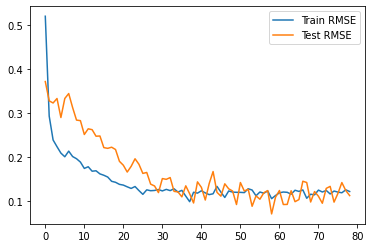

In [ ]:
#result of the DA model
plt.plot(hist_train[hist_train > 0], label="Train RMSE")
plt.plot(hist_test[hist_test > 0], label="Test RMSE")
plt.legend()
plt.show()

In [ ]:
print(np.mean(hist_train[hist_train > 0][-10:]), np.mean(hist_test[hist_test > 0][-10:]))

0.05950530613321089 0.09157783004607242


In [ ]:
print(np.nanmedian((abs(y_train_pred - y_train_iter) / y_train_iter).detach().numpy()),
np.nanmedian((abs(y_test_pred - y_test_iter) / y_test_iter).detach().numpy()))

0.11189182 0.1571007


In [ ]:
x = model.layer1(x_train.to(DEVICE))
x = model.layer2(x)
x = model.layer3(x)
x

tensor([[0.0503, 0.0000, 0.0198,  ..., 0.0000, 0.0270, 0.0000],
        [0.0000, 0.0000, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0380,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0539,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0523,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0277,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<ReluBackward0>)

In [ ]:
parm = {}
for name,parameters in model.named_parameters():
    print(name,':',parameters.size())
    parm[name]=parameters.cpu().detach().numpy()

layer1.0.weight : torch.Size([32, 3])
layer1.0.bias : torch.Size([32])
layer2.0.weight : torch.Size([16, 32])
layer2.0.bias : torch.Size([16])
layer3.0.weight : torch.Size([8, 16])
layer3.0.bias : torch.Size([8])
layer4.weight : torch.Size([1, 8])
layer4.bias : torch.Size([1])


In [ ]:
print(parm)

-change model structure, number of layers, units, and lr

-compare with MMD of total distribution

-change trade-off coefficients